## Introduction

Spatial omics technologies are transforming our ability to study biology by revealing not only what genes or proteins are expressed, but also where they are expressed within intact tissues. Traditional bulk or single-cell omics methods require dissociating cells, which removes all positional information and obscures how cells interact, organize, and form functional microenvironments. Spatial omics overcomes this limitation by combining molecular profiling with spatially resolved measurements, allowing researchers to map cellular identities, gene expression, and biological processes directly onto tissue architecture.

In this tutorial, we focus on single-cell spatial omics, a rapidly advancing branch of spatial biology that provides molecular measurements at (or near) single-cell resolution.

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# We use the Moffitt et al. (2018) MERFISH dataset built into Squidpy.

adata = sq.datasets.merfish()

# Quick QC & Preprocessing (Standard Scanpy workflow)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

print("Data Loaded:", adata)
print("Available Labels:", adata.obs['Cell_class'].unique())

/Users/yuxinshen/Documents/PhD/BioML_tutorial/.venv/lib/python3.9/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/yuxinshen/Documents/PhD/BioML_tutorial/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Data Loaded: AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
Available Labels: ['OD Mature 2', 'OD Immature 1', 'Inhibitory', 'Excitatory', 'Microglia', ..., 'OD Mature 4', 'Pericytes', 'OD Mature 3', 'Ependymal', 'OD Immature 2']
Length: 16
Categories (16, object): ['Ambiguous', 'Astrocyte', 'Endothelial 1', 'Endothelial 2', ..., 'OD Mature 2', 'OD Mature 3', 'OD Mature 4', 'Pericytes']


### 1. Dimensionality reduction and trajectory analysis

First, we conduct single-cell analysis without the spatial information.

In [2]:
X_pca = adata.obsm['X_pca'] 
y_labels = adata.obs['Cell_class']

# Clean up "NaN" labels
valid_cells = ~y_labels.isna()
X_clean = X_pca[valid_cells]
y_clean = y_labels[valid_cells]

# Run LDA
lda = LDA(n_components=9)
X_lda = lda.fit_transform(X_clean, y_clean)

# Put it back into the AnnData object
adata.obsm['X_lda'] = np.full((adata.n_obs, 9), np.nan)
adata.obsm['X_lda'][valid_cells] = X_lda


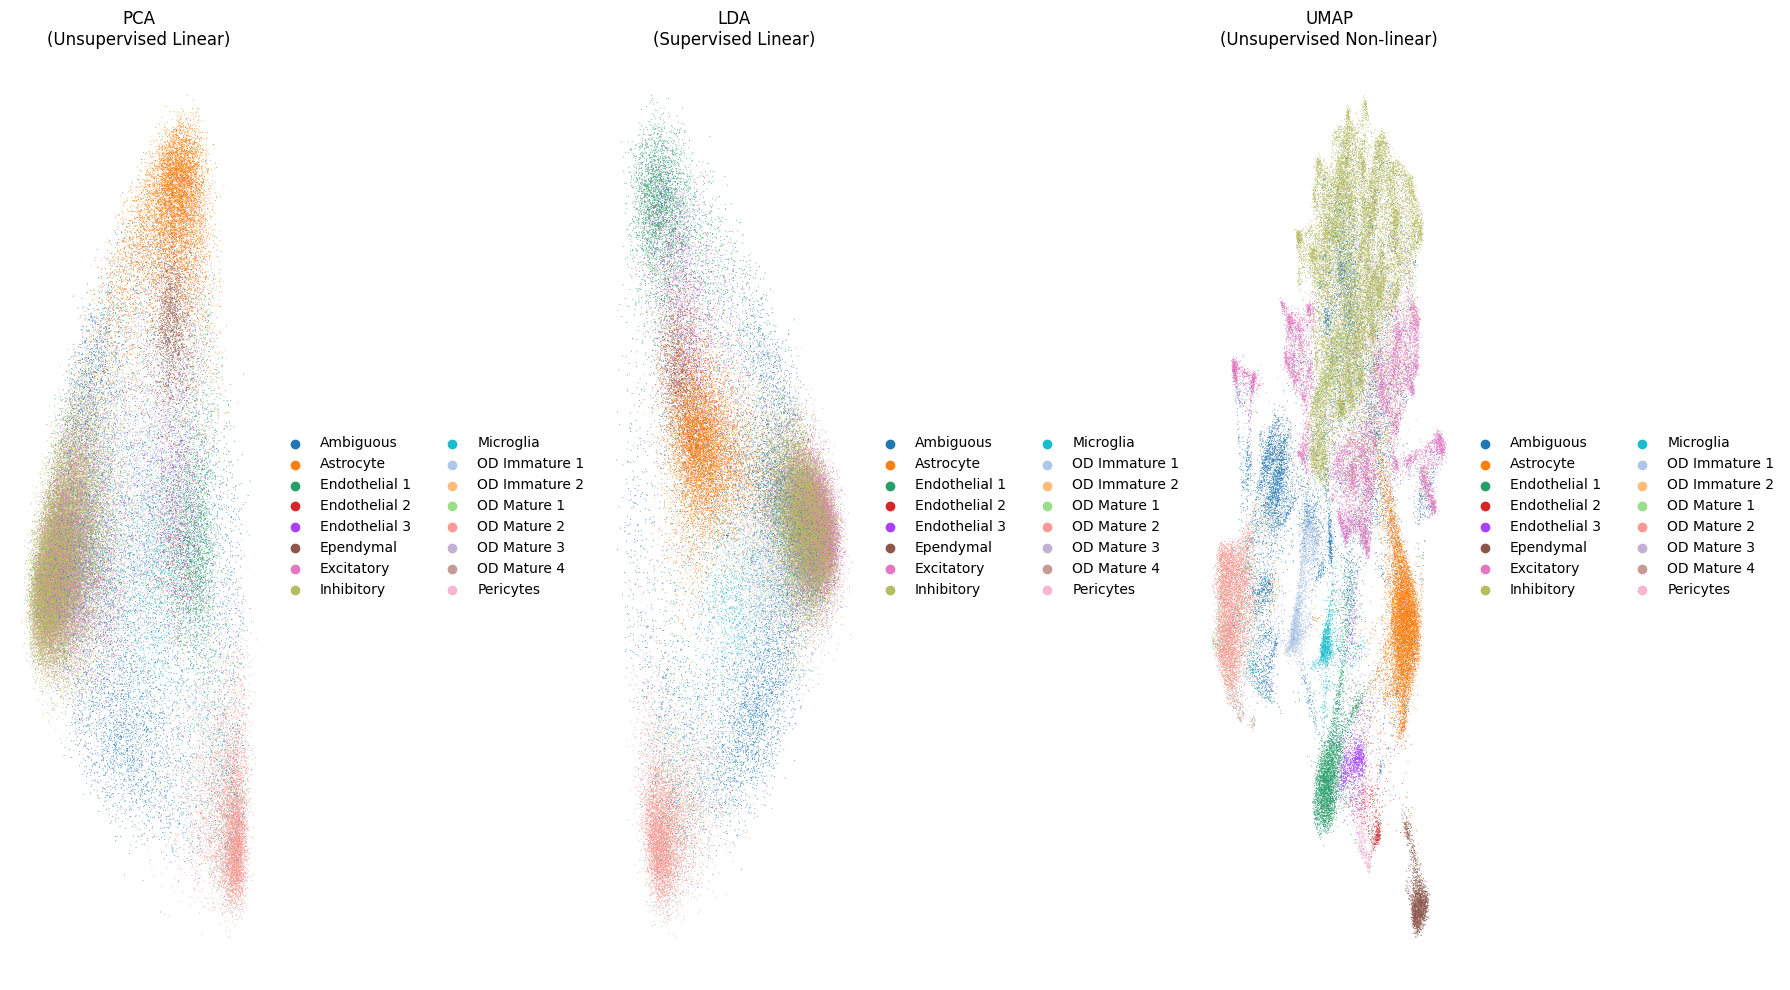

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))

sc.pl.embedding(adata, basis='X_pca', color='Cell_class', 
                title='PCA\n(Unsupervised Linear)', 
                ax=axs[0], show=False, frameon=False)

sc.pl.embedding(adata, basis='X_lda', color='Cell_class', 
                title='LDA\n(Supervised Linear)', 
                ax=axs[1], show=False, frameon=False)

sc.pl.umap(adata, color='Cell_class', 
           title='UMAP\n(Unsupervised Non-linear)', 
           ax=axs[2], show=False, frameon=False)

plt.tight_layout()
plt.show()

We then conduct trajectory analysis.

/Users/yuxinshen/Documents/PhD/BioML_tutorial/.venv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


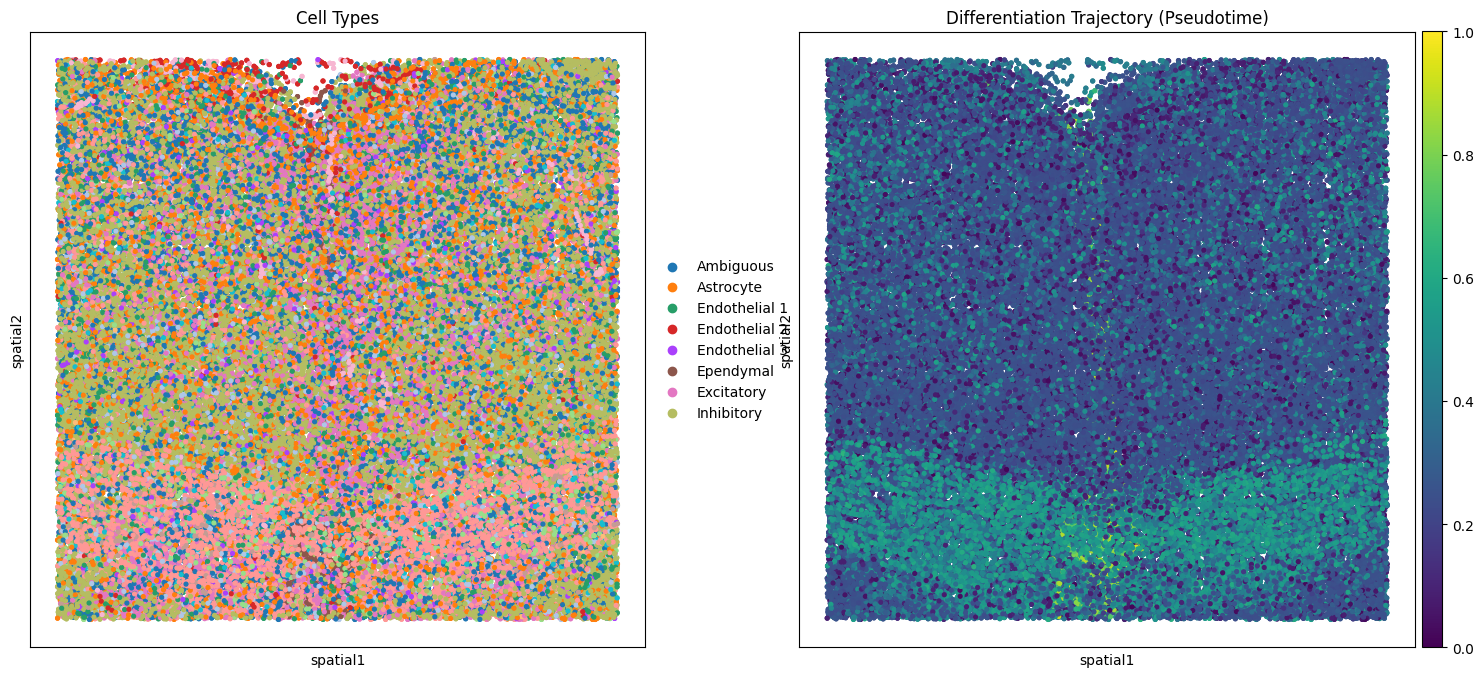

In [4]:
# Run Diffusion Map
sc.tl.diffmap(adata)

# Pick a random root cell
root_class = "Ependymal"
root_cell_index = np.where(adata.obs['Cell_class'] == root_class)[0][0]
adata.uns['iroot'] = root_cell_index

# Calculate Pseudotime (DPT)
sc.tl.dpt(adata)

# Visualize Trajectory in Space

sq.pl.spatial_scatter(
    adata, 
    shape=None, 
    color=["Cell_class", "dpt_pseudotime"], 
    size=30, # Adjust spot size 
    figsize=(8, 8),
    title=["Cell Types", "Differentiation Trajectory (Pseudotime)"]
)

### 2. LDA supervised by spatial information

We perform spatial transcriptomics analysis on Visium data by identifying tissue neighborhoods ("niches") and finding genes that define them.

/var/folders/3t/pvgbrjnn5m56z9knqqqkn9900000gn/T/ipykernel_22475/4051605477.py:22: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_niche, resolution=0.5, key_added='spatial_niche')


Found Spatial Niches: ['5', '6', '9', '8', '4', ..., '11', '10', '7', '2', '14']
Length: 15
Categories (15, object): ['0', '1', '2', '3', ..., '11', '12', '13', '14']


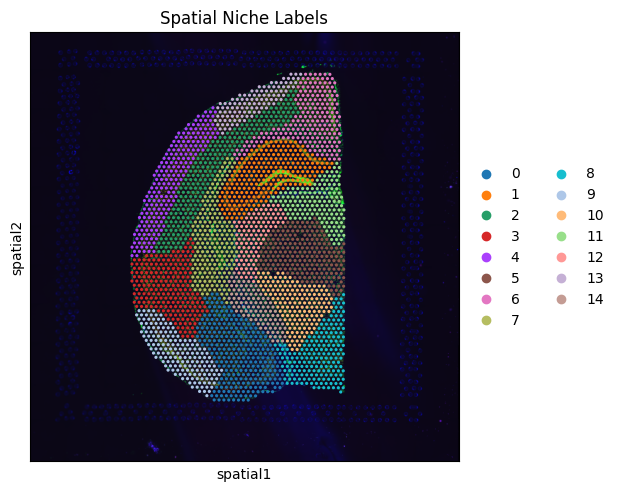

In [5]:
adata = sq.datasets.visium_fluo_adata()  
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)


# Compute Spatial Neighbors
sq.gr.spatial_neighbors(adata, n_neighs=10, coord_type="grid")

# Compute Spatially Lagged Features

W = adata.obsp['spatial_connectivities']

X_lagged = W @ adata.X 

X_lagged = X_lagged / W.sum(axis=1)


adata_niche = sc.AnnData(X=X_lagged)
sc.pp.pca(adata_niche)
sc.pp.neighbors(adata_niche)
sc.tl.leiden(adata_niche, resolution=0.5, key_added='spatial_niche')


adata.obs['spatial_niche'] = adata_niche.obs['spatial_niche'].values

print("Found Spatial Niches:", adata.obs['spatial_niche'].unique())

sq.pl.spatial_scatter(adata, color="spatial_niche", title="Spatial Niche Labels")




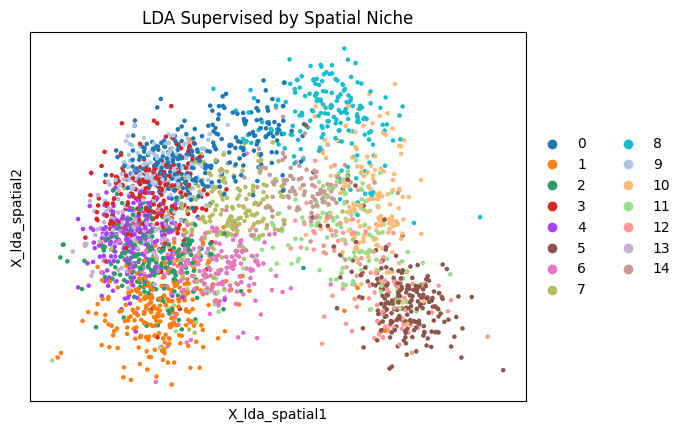

Top spatial drivers for Niche 0: ['Ccdc38' 'Fam24b' 'Tmem253' 'Gm9993' 'Rtl3' 'Olfr482' 'Gm47079' 'Capn9'
 '1700093K21Rik' 'Tdrd1']


In [6]:
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
y = adata.obs['spatial_niche']


lda = LDA(n_components=3) 
X_lda = lda.fit_transform(X, y)


adata.obsm['X_lda_spatial'] = X_lda


sc.pl.embedding(adata, basis='X_lda_spatial', color='spatial_niche', title="LDA Supervised by Spatial Niche")


# Get the genes that contribute most to the first LDA axis
feature_names = adata.var_names
top_genes_idx = np.argsort(np.abs(lda.coef_[0]))[-10:] 
print(f"Top spatial drivers for Niche 0: {feature_names[top_genes_idx].values}")